# Camera Calibration

This notebook aims to introduce the topic of camera calibration in a simple yet deep manner. Finding the camera intrinsics and extrinsics are done from sratch so one may understand the mathematics behind the subject. 

This notebook is as simple a representation as possible for camera calibration. Ignored topics: normalization of image points, Levenberg-Marquadt optimization and refinement of parameters, and distortion. 

Resources that deserve much credit: 
Stanford CS231A lecture notes. 
https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr98-71.pdf
https://www.learnopencv.com/camera-calibration-using-opencv/
http://ece631web.groups.et.byu.net/Lectures/ECEn631%2010%20-%20Homography%20Camera%20Calibration.pdf
http://ais.informatik.uni-freiburg.de/teaching/ws09/robotics2/pdfs/rob2-08-camera-calibration.pdf
https://kushalvyas.github.io/calib.html

For the best in depth tutorial with all topics covered deeply and thoroughly, please see: 
http://staff.fh-hagenberg.at/burger/publications/reports/2016Calibration/Burger-CameraCalibration-20160516.pdf

## Image Formation: From 3D point to 2D pixel position

### Homogenous Coordinates 

For reasons that will be explained later, we will use homogenous coordinates to express the pixel coordinates and 3D object space coordinates. This means we will simply add a 1 to the bottom of the column for each coordinate. This has to do with ambiguity in the relation from a pixel coordinate to the point in 3D object space. We don't know exactly how far along the ray direction from the camera to go; we only know the direction of the ray. 

In pixel space, we write this as: 
$[u, v, 1]^{T}$

In object space, we write this as: 
$[X_{c}, Y_{c}, Z_{c}, 1]^{T}$ 

We use the subscript $p$ for pixel space, and the subscript $c$ for camera object space. 

### Geometry of Image Formation: Focal Length 

We can look at the figure of how a pixel position appears in image space compared to where it appears in 3D object space. 

Using similar triangles, we see the pixel position is related to the focal length and distance from the camera. 

We have 

$x_{p} = f \frac{X_{c}}{Z_{c}}$ and $ y_{p} = f \frac{Y_{c}}{Z_{c}}$. 

This is unfortunately a non-linear transformation since we are dividing by $Z_c$. In order to have a linear transformation, we use our homogeneous coordinate representation. We can then use express this in matrix form. 

We can express this in matrix form as: 

\begin{equation}
\begin{bmatrix}
x'_{p} \\
y'_{p} \\
Z_{c} 
\end{bmatrix} = 
\begin{bmatrix}
f & 0 & 0 & 0 \\
0 & f & 0 & 0 \\ 
0 & 0 & 1 & 0
\end{bmatrix}
\begin{bmatrix}
X_{c} \\
Y_{c} \\
Z_{c} \\
1 
\end{bmatrix}
\end{equation}

In order to recover the point in Euclidean image space, we divide by the $Z_{c}$, taking us to a homogenous form: 

\begin{equation}
\begin{bmatrix}
x'_{p} \\
y'_{p} \\
Z_{c} 
\end{bmatrix} \rightarrow 
\begin{bmatrix}
u \\
v \\
1 
\end{bmatrix}
\end{equation} 

where we have $u = \frac{x'_{p}}{Z_{c}}$, etc. 

### Adjusting for Principal Point

We need to adjust for the fact that the center of the image is not where we want to have the origin, we want the origin to be at the bottom left corner of the image. To adjust for this, we express

$u = f \frac{X_{c}}{Z_{c}} + c_{x}$ and $ v = f \frac{Y_{c}}{Z_{c}}+c_{y}$

where $c_{x}$ and $c_{y}$ are offsets in image space to adjust for origin. Our matrix expression now takes the form: 


\begin{equation}
\begin{bmatrix}
x'_{p} \\
y'_{p} \\
Z_{c} 
\end{bmatrix} = 
\begin{bmatrix}
f & 0 & c_{x} & 0 \\
0 & f & c_{y} & 0 \\ 
0 & 0 & 1 & 0
\end{bmatrix}
\begin{bmatrix}
X_{c} \\
Y_{c} \\
Z_{c} \\
1 
\end{bmatrix}
\end{equation}

Notice this would now give
$x'_{p} = f X_{c} + c_{x} Z_{c} $, but when dividing by $Z_{c}$ to get our homogenous form, we'd obtain
$u = f \frac{X_{c}}{Z_{c}} + c_{x} $ which is what we expect in image space. 

### Adjusting for Meter to Pixel factor

Note that every value in object space is in meters. We need values in pixel coordinates. We need a conversion from meters to pixels. This can be handled as follows. 

$x_{p} = f k \frac{X_c}{Z_c} + c_{x} $ 

Note we first convert the meters to pixels, and then add on the pixel offset. The conversion factor $k$ has dimensions of $pixel/meter$. We will have a similar conversion in the y direction. The conversion factor need not be the same in both x and y. 

We can now account for this conversion in matrix formation as follows. 

\begin{equation}
\begin{bmatrix}
x'_{p} \\
y'_{p} \\
Z_{c} 
\end{bmatrix} = 
\begin{bmatrix}
\alpha & 0 & c_{x} & 0 \\
0 & \beta & c_{y} & 0 \\ 
0 & 0 & 1 & 0
\end{bmatrix}
\begin{bmatrix}
X_{c} \\
Y_{c} \\
Z_{c} \\
1 
\end{bmatrix}
\end{equation}

where $\alpha = f k $ and $\beta$ is defined in a similar manner. 

### Adjusting for Skew 

In some cases, there may be skew to be accounted for. For instance, the camera plane may not be aligned properly. We will not get into details, but this can be expressed in matrix form as follows. 

\begin{equation}
\begin{bmatrix}
x'_{p} \\
y'_{p} \\
Z_{c} 
\end{bmatrix} = 
\begin{bmatrix}
\alpha & s & c_{x} & 0 \\
0 & \beta & c_{y} & 0 \\ 
0 & 0 & 1 & 0
\end{bmatrix}
\begin{bmatrix}
X_{c} \\
Y_{c} \\
Z_{c} \\
1 
\end{bmatrix}
\end{equation}

### Intrinsics 

We finally can define our camera matrix as 

\begin{equation}
K = \begin{bmatrix}
\alpha & s & c_{x} & 0 \\
0 & \beta & c_{y} & 0 \\ 
0 & 0 & 1 & 0
\end{bmatrix}
\end{equation}

This matrix represents the intrinsic parameters of the camera. 

## Coordinate Transformations: World to Camera System

### Transform World Point to Camera System

We need to understand that we may not necessarily and most likely will not define 3D object points in terms of the camera coordinate system, but rather a different world coordinate system. 

We can express the transformation as 

\begin{equation}
\mathbf{X}_{c} = 
\begin{bmatrix}
\mathbf{R} & \mathbf{T} \\ 
0 & 1
\end{bmatrix}
\mathbf{X}_{w} 
\end{equation}

where $R$ is a $3\times 3$ rotation matrix and $T$ is a $3 \times 1$ column vector. The subscript $w$ refers to world coordinate system. Reference image for clarity. 


### Extrinsics 

This matrix that includes the rotation and translation referes to extrinsics of our system. 

## Full Projection Matrix 

We can now define our full projection matrix to take us from a world coordinate system to image pixel space. 

\begin{equation}
\mathbf{u} = \mathbf{P}
\mathbf{X}_{w}
\end{equation}

The matrix here is termed the projection matrix. 
\begin{equation}
\mathbf{P}= \mathbf{K} \begin{bmatrix}
\mathbf{R} & \mathbf{T} \\ 
0 & 1
\end{bmatrix} 
\end{equation}

## Solving for the Projection Matrix

### World Points on a Plane

We can calibrate a camera by taking known image points that have known correspondences in object space, form many equations, and then find our components of the projection matrix.  

For each point correspondence, we will obtain an expression for $u$ and $v$, which are the pixel coordinates in image space. Let us use $i$ as a subscript to describe the correspondence number. 

\begin{equation}
u_{i} = \frac{ p_{11} X_{w,i} + p_{12} Y_{w,i} + p_{13}Z_{w,i} + p_{14} }{ p_{31}X_{w,i} + p_{32}Y_{w,i} + p_{33} Z_{w,i} + p_{34} } 
\end{equation}

\begin{equation}
v_{i} = \frac{ p_{21} X_{w,i} + p_{22} Y_{w,i} + p_{23}Z_{w,i} + p_{24} }{ p_{31}X_{w,i} + p_{32}Y_{w,i} + p_{33} Z_{w,i} + p_{34} } 
\end{equation}

These equations can be re-arranged to have a linear system for the elements of $P$. For $i = 1...n$ correspondences, we can have the following. 

\begin{equation}
\begin{bmatrix}
X_{1} & Y_{1} & Z_{1} & 1 & 0 & 0 & 0 & 0 & -u_{1}X_{1} & -u_{1}Y_{1} & -u_{1}Z_{1} & -u_{1} \\
0 & 0 & 0 & 0 & X_{1} & Y_{1} & Z_{1} & 1 & -v_{1}X_{1} & -v_{1}Y_{1} & -v_{1}Z_{1} & -v_{1} \\
X_{2} & Y_{2} & Z_{2} & 1 & 0 & 0 & 0 & 0 & -u_{2}X_{2} & -u_{2}Y_{2} & -u_{2}Z_{2} & -u_{2} \\
0 & 0 & 0 & 0 & X_{2} & Y_{2} & Z_{2} & 1 & -v_{2}X_{2} & -v_{2}Y_{2} & -v_{2}Z_{2} & -v_{2} \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
X_{n} & Y_{n} & Z_{n} & 1 & 0 & 0 & 0 & 0 & -u_{n}X_{n} & -u_{n}Y_{n} & -u_{n}Z_{n} & -u_{n} \\
0 & 0 & 0 & 0 & X_{n} & Y_{n} & Z_{n} & 1 & -v_{n}X_{n} & -v_{n}Y_{n} & -v_{n}Z_{n} & -v_{n} 
\end{bmatrix}
\begin{bmatrix}
p_{11} \\
p_{12} \\
p_{13} \\
p_{14} \\
p_{21} \\
p_{22} \\
p_{23} \\
p_{24} \\
p_{31} \\
p_{32} \\
p_{33} \\
p_{34} 
\end{bmatrix}
= \mathbf{0}
\end{equation}

Let's express this mathematically as 

\begin{equation}
\mathbf{A}\mathbf{p} = \mathbf{0}
\end{equation}

### Number of Correspondences 

The above linear system shows 12 elements in the  $p$ vector that should be solved for. However, there are actually only 11 independent elements, since scale is arbitrary as mentioned previously. Given that for a single correspondence, we get two equations, we know we need 6 correspondences at least to be able to solve this system. 

### Solution of the Linear System 

We have the linear system 

\begin{equation}
\mathbf{A} \mathbf{p} = 0
\end{equation}

where $\mathbf{A} \in \mathbb{R}^{2n \times 12} $ and $\mathbf{p} \in \mathbb{R}^{12 \times 1} $, where $n$ is the number of correspondence points. 

The solution to this minimizes the left hand side in the 2-norm. This corresponds to the unit eigenvector corresponding to the smallest eigenvector of the matrix $\mathbf{A}^{T} \mathbf{A}$. We solve this using the singular value decomposition. 

\begin{equation}
A = U \Sigma V^{T}
\end{equation}

The last colum nof $V^{T}$ corresponds to the smallest singular value $\sigma_{12}$. The singular values are just square roots of the eigen values of $A^{T} A$, but we are merely interested in the vector associated. 

### Decomposing Projection Matrix into Intrinsics and Extrinsics

After we have solved for our vector $p$, we reshape it to a 3x4 matrix. We again use the definition of the projection matrix. 

\begin{equation}
\mathbf{P}= \mathbf{K} \begin{bmatrix}
\mathbf{R} & \mathbf{T} \\ 
0 & 1
\end{bmatrix} 
\end{equation}

We can decompose the first 3x3 sub-matrix of the projection matrix using a $QR$ factorization. This gives an upper triangular matrix $Q$ which will be our $K$ matrix. The $R$ matrix is also our $R$ matrix; the rotation. 

### Homography Representation 



When performing camera calibration, it is common to use a checkerboard plane to define image features and object points. A checkerboard is a well defined 2D plane in world space. If we set the Z coordinate of the checkerboard to be zero, we can see our projection matrix becomes 

\begin{equation}
\begin{bmatrix}
u \\
v \\ 
1 \\ 
\end{bmatrix} = 
\lambda \mathbf{K}
\begin{bmatrix}
\mathbf{r_{1}} & \mathbf{r_{2}} & \mathbf{r_{3}} & \mathbf{t}
\end{bmatrix}
\begin{bmatrix}
X_{w} \\ 
Y_{w} \\ 
0 \\
1
\end{bmatrix}
\end{equation}

This in turn erases the third column of the rotation, giving. 

\begin{equation}
\begin{bmatrix}
u \\
v \\ 
1 \\ 
\end{bmatrix} = 
\lambda \mathbf{K}
\begin{bmatrix}
\mathbf{r_{1}} & \mathbf{r_{2}} & \mathbf{t}
\end{bmatrix}
\begin{bmatrix}
X_{w} \\ 
Y_{w} \\ 
1
\end{bmatrix} = 
\mathbf{H}
\begin{bmatrix}
X_{w} \\ 
Y_{w} \\ 
1
\end{bmatrix}
\end{equation}

NOTE: We've included a $\lambda$ term because we know this projection only up to a scale factor. This is due to our homogeneous coordinate representation. 

We can now form this homography matrix by taking object points defined on a plane, such as a checkerboard, and the corresponding image space points. We can then re-arrange our equations similarly to how we did for the $\mathbf{P}$ matrix and find an expression as follows: 

\begin{equation}
\mathbf{A} \mathbf{h} = 0
\end{equation}

where now the $\mathbf{A}$ matrix looks as follows: 

\begin{equation}
\begin{bmatrix}
X_{1} & Y_{1}  & 1 & 0 & 0 & 0 & 0 & -u_{1}X_{1} & -u_{1}Y_{1}  & -u_{1} \\
0 & 0 & 0 & 0 & X_{1} & Y_{1}  & 1 & -v_{1}X_{1} & -v_{1}Y_{1}  & -v_{1} \\
X_{2} & Y_{2}  & 1 & 0 & 0 & 0 & 0 & -u_{2}X_{2} & -u_{2}Y_{2}  & -u_{2} \\
0 & 0 & 0 & 0 & X_{2} & Y_{2} & 1 & -v_{2}X_{2} & -v_{2}Y_{2} & -v_{2} \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
\vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
X_{n} & Y_{n} & 1 & 0 & 0 & 0 & 0 & -u_{n}X_{n} & -u_{n}Y_{n}  & -u_{n} \\
0 & 0 & 0 & 0 & X_{n} & Y_{n}  & 1 & -v_{n}X_{n} & -v_{n}Y_{n} & -v_{n} 
\end{bmatrix}
\begin{bmatrix}
h_{11} \\
h_{12} \\
h_{13} \\
h_{21} \\
h_{22} \\
h_{23} \\
h_{31} \\
h_{32} \\
h_{33}
\end{bmatrix}
= \mathbf{0}
\end{equation}

We can again solve this by using the singular value decomposition as described earlier. 

\begin{equation}
A = U \Sigma V^{T}
\end{equation}

The last column of $V$ corresponds to the $h$ vector we are interested in. We can take this and reshape it to be 3x3 and we will have our homography $H$. 

Let's write a python function below that takes object points and image points for a certain image view, and returns the A matrix as shown above. We then have a function that takes that matrix and finds a homography. We also define a function that solves a linear homogeneous system as we will need this at several steps of our calibration. 

In [2]:
def solve_homogenous_linear_system(A):

    u, s, vh = np.linalg.svd(A) 
    x = vh[np.argmin(s)]

    return x 

def create_A_matrix(object_points,image_points):

    num_correspondences = len(object_points)
    A = np.zeros((2*num_correspondences,9),dtype=np.float64)

    for i in range(0,num_correspondences): 
        X = object_points[i,0]
        Y = object_points[i,1]
        u = image_points[i,0]
        v = image_points[i,1]

        row_1 = np.array([-X,-Y,-1.0,0,0,0,u*X,u*Y,u])
        row_2 = np.array([0,0,0,-X,-Y,-1.0,v*X,v*Y,v])

        A[(2*i)] = row_1
        A[(2*i)+1] = row_2 


    return A

def find_homography(A):

    h = solve_homogenous_linear_system(A) 
    H = np.reshape(h,(3,3))
    norm = H[2,2]
    H = H[:,:]/norm

    return H 

Let's say for each view, we have solved for the homography. How do we then get our camera parameters (intrinsics) and position and orientation (extrinsics). We show below a way to do just that. 

Let's again re-visit the definition of the homography. 

\begin{equation}
H = [h_{1} h_{2} h_{3}] = \lambda K [r_{1} r_{2} t]
\end{equation}

This means that 
\begin{equation}
r_{1} = \frac{1}{\lambda} K^{-1} h_{1} 
\end{equation}
\begin{equation}
r_{2} = \frac{1}{\lambda} K^{-1} h_{2} 
\end{equation}
\begin{equation}
t = \frac{1}{\lambda} K^{-1} h_{3} 
\end{equation}


with $\lambda = 1 / ||K^{-1} h_{1}||$ 


We know that the rotation vectors $r_{1}$ and $r_{2}$ must be orthogonal, which yields
\begin{equation}
r_{1}^{T} r_{2} = (\frac{1}{\lambda} K^{-1} h_{1})^T \frac{1}{\lambda} K^{-1} h_{2} = 
h_{1}^{T} K^{-T} K^{-1} h_{2} = 0
\end{equation}

We can also use the fact that the rotation vectors must be of unit length and so their lenghts are equal, yielding
\begin{equation}
r_{1}^{T}r_{1} = r_{2}^{T}r_{2} 
\end{equation}

We insert their definitions and find
\begin{equation}
h_{1}^{T}K^{-T}K^{-1}h_{1} - h_{2}^{T}K^{-T}K^{-1}h_{2} = 0
\end{equation}

Let us now define a matrix $B = K^{-T}K^{-1}$

We see that $B$ is symmetric positive definite (SPD). We can also express it in a vector form with six individual unique components and define: 

\begin{equation}
h_{i}^{T} B h_{j} = v_{ij}^{T} b
\end{equation}

where we define 
\begin{equation} 
v_{ij}^{T} = 
\begin{bmatrix}
h_{i,1} h_{j,1} \\
h_{i,1}h_{j,2} + h_{i,2}h_{j,1} \\
h_{i,2} h_{j,2} \\
h_{i,3}h_{j,1} + h_{i,1} h_{j,3} \\
h_{i,3}h_{j,2} + h_{i,2} h_{j,3} \\
h_{i,3} h_{j,3} \\
\end{bmatrix}^{T}
\end{equation}

We can then use the two constraints we have which are 

$v_{12}^{T} b = 0$ and $(v_{11}^T - v_{22}^T)b = 0$ to set up the following

\begin{equation}
\begin{bmatrix}
v_{12}^T \\ 
v_{11}^T - v_{22}^T 
\end{bmatrix} b = Vb = 0
\end{equation}

The matrix $V$ is of dimension $2k \times 6$ and the vector $b$ here is $6\times 1$, where $k$ is the number of image views we have (the number of calibration images). 

Now we again can use the SVD to solve for the vector $b$ and use it to populate $B = K^{-T}K^{-1}$

We can then use a Cholesky factorization on $B$ to determine the matrix $K$. We have then found our intrinsic matrix. 
The Cholesky factoraization gives

\begin{equation}
B = L L^T = K^{-T}K^{-1}
\end{equation}

This tells us 
\begin{equation}
L = K^-1
\end{equation}

which means $K = L^-1$

Another way to obtain the entries of the matrix K is to note the definition again $B = L L^T = K^{-T}K^{-1}$ and solve by hand since $K$ has an upper triangular form it can be inverted analytically. In Zhang's notes, he defines how to find these values. 

\begin{equation}
K_{11} = \alpha = \sqrt{l / b_{1}}
\end{equation}
\begin{equation}
K_{12} = \gamma = -b_{1} \alpha^{2} (\beta/ l)
\end{equation}
\begin{equation}
K_{13} = u_{c} = (\gamma v_{c} /\beta) - (b_{3} \alpha^{2}/l)
\end{equation}
\begin{equation}
K_{22} = \beta = \sqrt{(l / b_{0})/(b_{0}b_{2} - b_{1}^2}
\end{equation}
\begin{equation}
K_{23} = v_{c} = (b_{1}b_{3} - b_{0}b_{4})/(b_{0}b_{2} - b_{1}^2)
\end{equation}
where 

\begin{equation}
l = b_{5} - (b_{3}^2 + vc(b_{1}b_{2} - b_{0}b_{4}))/b_{0}
\end{equation}

We are now only missing the rotation vector $r_{3}$. We use the cross product to find it. 

\begin{equation}
r_{3} = r_{1} \times r_{2}
\end{equation} 

We may not get our rotation matrix to be orthogonal due to noise, so we use SVD to enforce it. 

We create $\hat{R}$ from the three rotation vectors we have, then have 

\begin{equation}
\hat{R} = U \Sigma V^{T} 
\end{equation}

We now replace the $\Sigma$ with an identity matrix to ensure orthogonality and finally have. 

\begin{equation}
R = U V^{T} 
\end{equation}

Below we will write some functions to find these matrices and values. 

In [3]:
def create_v_submatrix(H,i,j):
    Hi = H[:,i]
    Hj = H[:,j]
    
    v = np.zeros(6)
    v[0] = Hi[0]*Hj[0]
    v[1] = Hi[0]*Hj[1] + Hi[1]*Hj[0]
    v[2] = Hi[1]*Hj[1]
    v[3] = Hi[2]*Hj[0] + Hi[0]*Hj[2]
    v[4] = Hi[2]*Hj[1] + Hi[1]*Hj[2]
    v[5] = Hi[2]*Hj[2]
    
    return v 

def create_V_matrix(H):
    v_12 = create_v_submatrix(H,0,1)
    v_11 = create_v_submatrix(H,0,0)
    v_22 = create_v_submatrix(H,1,1)
    
    V = np.vstack([v_12,v_11-v_22])
    
    return V 

def find_b_vector(V):
    b = solve_homogenous_linear_system(V) 
    return b 

def create_B_matrix_from_vector(b):
    B = np.zeros((3,3))
    B[0,0] = b[0]
    B[0,1] = b[1]
    B[0,2] = b[3]
    B[1,1] = b[2]
    B[1,2] = b[4]
    B[2,2] = b[5]
    
    B[1,0] = B[0,1]
    B[2,0] = B[0,2]
    B[2,1] = B[1,2]
    
    return B 

def get_K_from_B(B):

    L = np.linalg.cholesky(B) 
    s = L[2,2]
    K = s * np.linalg.inv(L.T)

    return K 

def get_K_from_b_zhang(b):

    vc = (b[1]*b[3] - b[0]*b[4])/(b[0]*b[2] - b[1]**2)
    l = b[5] - (b[3]**2 + vc*(b[1]*b[2] - b[0]*b[4]))/b[0]
    alpha = np.sqrt((l/b[0]))
    beta = np.sqrt(((l*b[0])/(b[0]*b[2] - b[1]**2)))
    gamma = -1*((b[1])*(alpha**2) *(beta/l))
    uc = (gamma*vc/beta) - (b[3]*(alpha**2)/l)

    K = np.array([
            [alpha, gamma, uc],
            [0, beta, vc],
            [0, 0, 1.0],
        ])

    return K 

def get_extrinsics(K,H):
    Kinv = np.linalg.inv(K)
    lmbda = 1/np.linalg.norm(np.dot(Kinv,H[:,0]))

    r0 = lmbda * np.dot(Kinv,H[:,0])
    r1 = lmbda * np.dot(Kinv,H[:,1])
    t = lmbda * np.dot(Kinv,H[:,2])

    r2 = np.cross(r0,r1)

    Rhat = np.zeros((3,3))
    Rhat[:,0] = r0 
    Rhat[:,1] = r1 
    Rhat[:,2] = r2 

    u,s,vh = np.linalg.svd(Rhat)
    R = np.dot(u,vh)

    #Ensure rotation matrix is orthogonal 
    assert(np.abs(np.dot(R[:,0],R[:,1])) <= 1e-10)
    assert(np.abs(np.dot(R[:,0],R[:,2])) <= 1e-10)
    assert(np.abs(np.dot(R[:,2],R[:,1])) <= 1e-10)

    return R, t


# Full Example

We will now go through a full example of camera calibration, starting with a set of checkerboard images. Given the images, we can find a set of point correspondences from world space to image space. We will encode each linear system above, and decopose the matrix to find our camera intrinsics and extrinsics.

For this notebook, we've saved some image correspondence data we have saved prior. We will use this data for the examples. 

However, below we show a quick example of how to find and detect checkerboard corners. We guide you to the resources below for further implementation. 

## Calibration Images 

In camera calibration, images of a checkerboard are generally used. Checkerboard patterns allow for easy corner detection in the image, which automatically gives us the image points. In world space, we define a corner of the checkerboard as the origin and can then find the world to image space points we need. Examples of checkerboard images are shown below. We first show the checkerboard image, then the code for detection, then the detected features in image space. 

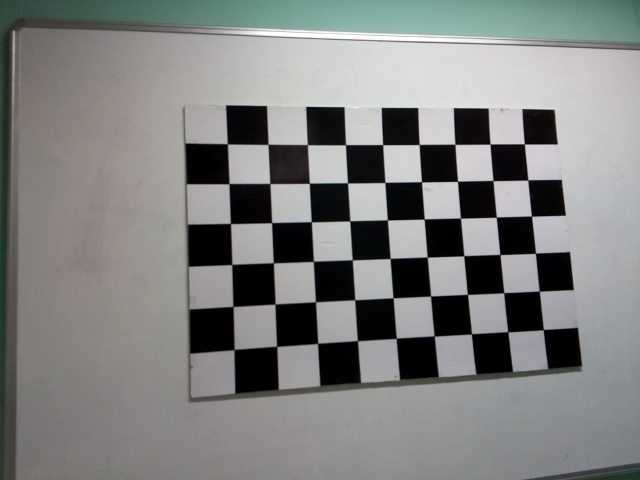

In [4]:
#Import library
from IPython.display import Image
# Load image from local storage
Image(filename = "image_test/image_2.jpg", width = 400, height = 200)

In [5]:
import cv2 as cv 
import numpy as np

filename = 'image_test/image_2.jpg'
img = cv.imread(filename)
print(np.shape(img))

gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv.cornerHarris(gray,2,3,0.04)

dst = cv.dilate(dst,None)
img[dst>0.01*dst.max()]=[0,0,255]

# #Uncomment below to see detected image
# cv.imshow('dst',img)
# if cv.waitKey(0) & 0xff == 27:
#     cv.destroyAllWindows()

(480, 640, 3)


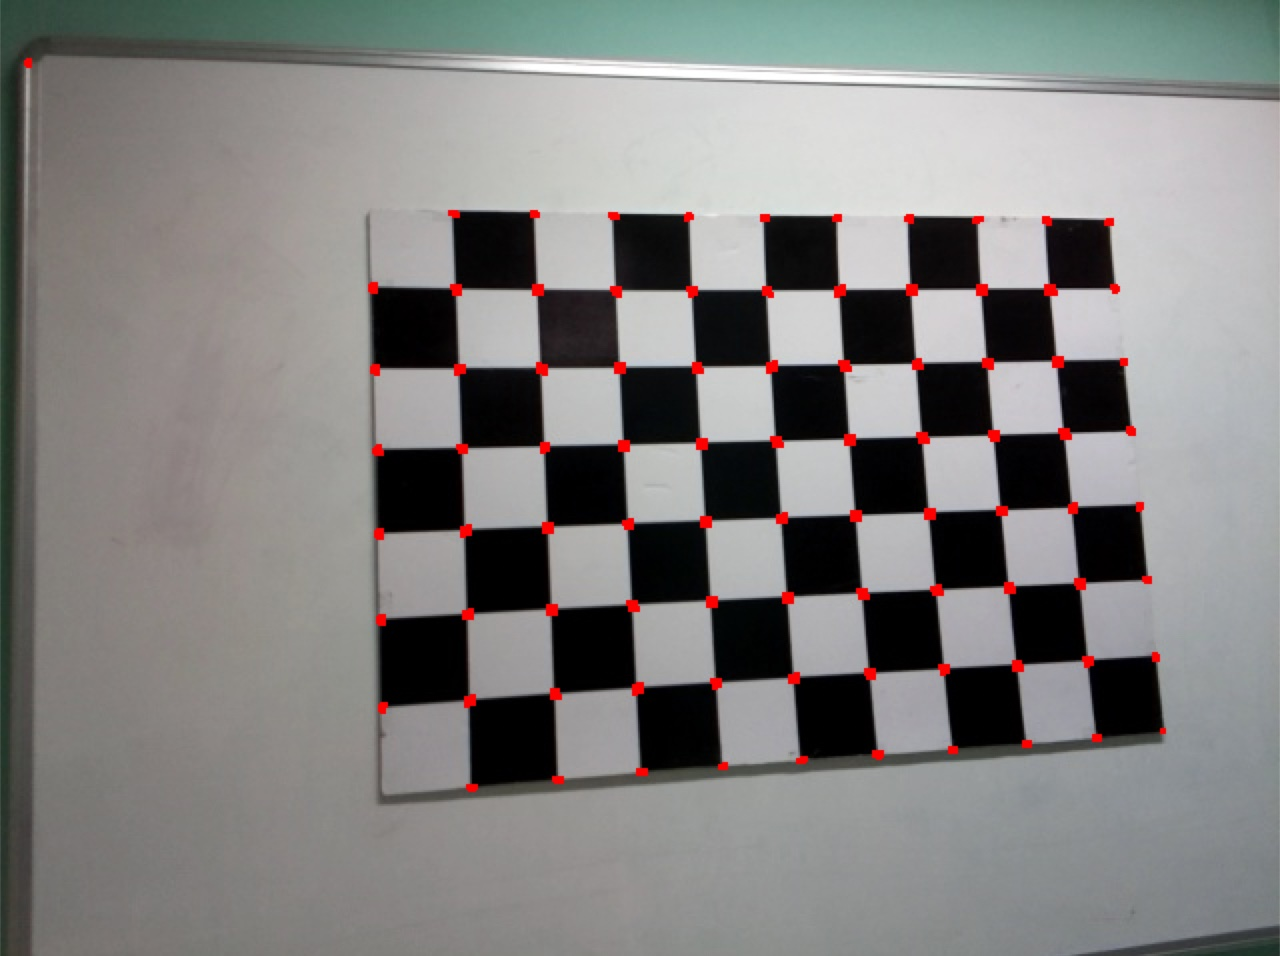

In [6]:
# Load image from local storage
Image(filename = "image_2_detected.jpg", width = 400, height = 200)

We will use built in opencv methods to find the corresponding image points and object points. We reference and give credit to Learn OpenCV: https://www.learnopencv.com/camera-calibration-using-opencv/

Our goal is to use the built in method for camera calibration, and then compare to our method and see if we obtain the same solution. We will use the object points and the image points. 

In [26]:
import cv2
import numpy as np
import os
import glob

# Defining the dimensions of checkerboard
CHECKERBOARD = (6,9)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Creating vector to store vectors of 3D points for each checkerboard image
objpoints = []
# Creating vector to store vectors of 2D points for each checkerboard image
imgpoints = []


# Defining the world coordinates for 3D points
objp = np.zeros((1, CHECKERBOARD[0]*CHECKERBOARD[1], 3), np.float32)
objp[0,:,:2] = np.mgrid[0:CHECKERBOARD[0], 0:CHECKERBOARD[1]].T.reshape(-1, 2)
prev_img_shape = None

# Extracting path of individual image stored in a given directory
images = glob.glob('./image_test/*.jpg')
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    # If desired number of corners are found in the image then ret = true
    ret, corners = cv2.findChessboardCorners(gray, CHECKERBOARD, cv2.CALIB_CB_ADAPTIVE_THRESH+
    	cv2.CALIB_CB_FAST_CHECK+cv2.CALIB_CB_NORMALIZE_IMAGE)

    """
    If desired number of corner are detected,
    we refine the pixel coordinates and display
    them on the images of checker board
    """
    if ret == True:
        objpoints.append(objp)
        # refining pixel coordinates for given 2d points.
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)

        imgpoints.append(corners2)

    #     # Draw and display the corners
    #     img = cv2.drawChessboardCorners(img, CHECKERBOARD, corners2,ret)
    #
    # cv2.imshow('img',img)
    # cv2.waitKey(0)

cv2.destroyAllWindows()

h,w = img.shape[:2]

"""
Performing camera calibration by
passing the value of known 3D points (objpoints)
and corresponding pixel coordinates of the
detected corners (imgpoints)
"""
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

print("Camera matrix : \n")
print(mtx)
print("dist : \n")
print(dist)
print("rvecs : \n")
print(rvecs)
print("tvecs : \n")
print(tvecs)
print("RMS Error: \n")
print(ret)

Camera matrix : 

[[504.21681043   0.         313.26055467]
 [  0.         503.77383906 242.81552881]
 [  0.           0.           1.        ]]
dist : 

[[ 2.01294867e-01 -4.03769308e-01  2.13773160e-04 -1.55470607e-03
   1.47580262e-01]]
rvecs : 

[array([[0.33280848],
       [0.55957115],
       [1.39495938]]), array([[-0.31073343],
       [ 0.1486898 ],
       [ 1.57735515]]), array([[0.3135697 ],
       [0.58863022],
       [1.39872247]]), array([[-0.29887024],
       [ 0.1841502 ],
       [ 1.57459072]]), array([[-0.2367753 ],
       [ 0.2202286 ],
       [ 1.56009804]]), array([[-0.2349131 ],
       [-0.04779996],
       [ 1.52228828]]), array([[-0.44650194],
       [-0.3074975 ],
       [ 1.53824887]]), array([[-0.69530087],
       [-0.57529349],
       [ 1.45066626]])]
tvecs : 

[array([[ 2.78913235],
       [-2.70222813],
       [ 9.4790687 ]]), array([[ 5.49124312],
       [-0.99835888],
       [12.7965539 ]]), array([[ 2.571406  ],
       [-2.02697745],
       [ 9.89320642]

We see get a solution above. Let's inspect the dimensions of the object points and the image points. 

In [408]:
print("Dimensions of objpoints: ", np.shape(objpoints))
print("Dimensions of imgpoints: ", np.shape(imgpoints))

Dimensions of objpoints:  (8, 1, 54, 3)
Dimensions of imgpoints:  (8, 54, 1, 2)


We see that the dimensions look a bit confusing, but let's understand. The first number in both dimensions gives the total number of image views used. Since we had two checkerboard images in our data set for now, we have two views. 

In the objpoints variable, for each view, we have 54 corners detected, each of 3 dimensions for (X,Y,Z) in world space. The imgpoints shows the same 54 corners detected, but then with 2 dimension since we are dealing with image space. 

We note that we will now be defining the world Z plane as zero, so we will use a homography representation as follows. 

Let's now choose a data file to find our correspondence set. For each view, we have a .csv file with the world points (object points) and image points. We define a function below to read the files for each view and have a list for them. 

In [8]:
def read_correspondeces_from_folder(folder_name):

    files = glob.glob(os.path.join(folder_name,"*.csv"))

    object_points_list = []
    image_points_list = []
    for file in files: 
        df = pd.read_csv(file) 
        object_points = df[["World X","World Y"]].values 
        image_points = df[["Image X","Image Y"]].values

        object_points_list.append(object_points)
        image_points_list.append(image_points)

    return object_points_list, image_points_list


In [10]:
import pandas as pd 
import numpy as np 
import copy 
import glob 
import os 

folder_name = "./example_data_opencv/"
object_points_list, image_points_list = read_correspondeces_from_folder(folder_name)

In [16]:
print("Number of views/images:", len(object_points_list))
print("Find A matrix and homography for each view.")

Number of views/images: 8
Find A matrix and homography for each view.


In [19]:
A_list = [] 
for (object_points,image_points) in zip(object_points_list,image_points_list): 
    A = create_A_matrix(object_points,image_points)
    A_list.append(A) 

H_list = [] 
for A in A_list: 
    H = find_homography(A) 
    H_list.append(H) 
    
print("For each homography, create a V matrix, then find K.")

For each homography, create a V matrix, then find K


In [35]:
#Find Intrinsicss
V_list = []
for H in H_list: 
    V = create_V_matrix(H)
    V_list.append(V)
V_all_views = np.vstack(V_list)
b = find_b_vector(V_all_views) 
#Two methods to find Intrinsic Parameters
Kzhang = get_K_from_b_zhang(b) 
B = create_B_matrix_from_vector(b)
Kcholesky = get_K_from_B(B) 

#Find Extrinsics
R_list = [] 
T_list = [] 
for H in H_list: 
    R, T = get_extrinsics(Kcholesky,H)
    R_list.append(R)
    T_list.append(T)

In [36]:
print("K using Zhang's method: ")
print(Kzhang)
print("K using Cholesky factorization: ")
print(Kcholesky)
print("K using OpenCV")
print(mtx)

K using Zhang's method: 
[[494.17320227   2.19012535 316.74285677]
 [  0.         497.01465787 241.90641399]
 [  0.           0.           1.        ]]
K using Cholesky factorization: 
[[493.83154641   2.18861117 316.74285677]
 [  0.         496.67103751 241.90641399]
 [  0.           0.           1.        ]]
K using OpenCV
[[504.21681043   0.         313.26055467]
 [  0.         503.77383906 242.81552881]
 [  0.           0.           1.        ]]


We see that the two methods used to find the K matrix from scratch and the OpenCV method align nicely. We note our approach is simplified. As explained earlier, we are not normalizing points in image space (which can have numerical affects), nor are we refining our paramters in a non-linear fashion as advised by Zhang and others. With that said, our very simple approach performs well. 

A way that we can quantify how well our calibration performs is to find what is called the reprojection error. We want to use our homographies to project our known object points to image space, and see how close our projected points compare to the true image space values. Let's define this mathematcially as: 

Our projected image space values for the $k^{th}$ image/view are found as: 
\begin{equation}
\hat{ \mathbf{u}}_{i} = \mathbf{H}_{k} \mathbf{X}_{i} 
\end{equation} 

where the index here is for the $i^{th}$ correspondence points. 

Our error is found as 
\begin{equation}
|| \mathbf{u}_{i} - \hat{ \mathbf{u}}_{i} ||_{2} 
\end{equation}

We sum all of these values over all correspondence points, and over all images/views, and then take that value and find its RMS error. 

\begin{equation}
RMS = \sqrt{\frac{\sum_{k}^{N_{views}} \sum_{i}^{N_{correspondences}}|| \mathbf{u}_{i} - \hat{ \mathbf{u}}_{i} ||_{2} }{N_{samples}}}
\end{equation}

where $N_{samples}$ is the total number of correspondences over all images. 
Let's write a function that does this. 

In [37]:
def rms_error(H_list, object_points_list, image_points_list): 
    
    rms = 0
    num_samples = 0
    for k,H in enumerate(H_list): 
        object_points = object_points_list[k]
        image_points = image_points_list[k]
        
        num_samples += len(object_points)
        
        for (object_point, image_point) in zip(object_points,image_points): 
            
            homogenous_object_point = np.array([object_point[0],object_point[1],1.0])
            predicted_image_point = np.dot(H,homogenous_object_point)
            #Only know the predicted image points up to a scale, divide by last value
            predicted_image_point = predicted_image_point/predicted_image_point[2]
            predicted_image_point = predicted_image_point[:2]
            
            error = np.linalg.norm(predicted_image_point-image_point)
            
            rms += error 
            
    #After all views and all correspondences calculated, find rms error 
    rms = np.sqrt(rms/num_samples)
    
    return rms 
        

In [38]:
rms = rms_error(H_list,object_points_list,image_points_list)
print("RMS from our method.")
print("rms error: ", rms, " pixels ")
print("RMS from OpenCV.")
print("rms error: ", ret, " pixels ")

RMS from our method.
rms error:  0.6965095555772043  pixels 
RMS from OpenCV.
rms error:  0.2076194988498791  pixels 


Again we see that OpenCV has a better performance than we do. However we note we still have less than one pixel RMS error over all views and correspondences which is excellent. 

That is all for this notebook, I hope you now feel empowered to perform AND understand camera calibration!